In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pennylane as qml
from torchvision.models import resnet18, vgg16, mobilenet_v2, inception_v3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

In [ ]:
# Define constants
n_qubits = 4
n_layers = 2
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up the quantum device
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode the classical data into quantum states
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Quantum layers
    for l in range(n_layers):
        for i in range(n_qubits):
            qml.RZ(weights[l][i][0], wires=i)
            qml.RY(weights[l][i][1], wires=i)

        # Entangling layers
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])
        qml.CNOT(wires=[n_qubits-1, 0])

    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        batch_size = x.shape[0]
        # Process each sample in the batch separately
        outputs = []
        for i in range(batch_size):
            sample = x[i].reshape(n_qubits)
            output = self.qlayer(sample)
            outputs.append(output)
        return torch.stack(outputs)

In [ ]:
# Base class for all hybrid models
class BaseHybridModel(nn.Module):
    def __init__(self, backbone, feature_size, num_classes=3):
        super().__init__()
        self.backbone = backbone

        # Add quantum layer with proper feature reduction
        self.feature_reducer = nn.Sequential(
            nn.Linear(feature_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_qubits)
        )
        self.quantum_layer = QuantumLayer()

        # Final classification layer
        self.classifier = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        # Classical features from backbone
        features = self.backbone(x)

        # Reduce features for quantum processing
        reduced_features = self.feature_reducer(features)

        # Quantum processing
        quantum_out = self.quantum_layer(reduced_features)

        # Final classification
        return self.classifier(quantum_out)

In [ ]:
# ResNet18 Hybrid Model
class ResNet18Hybrid(BaseHybridModel):
    def __init__(self, num_classes=3):
        # Load pre-trained ResNet18
        backbone = resnet18(pretrained=True)
        feature_size = backbone.fc.in_features
        backbone.fc = nn.Identity()

        super().__init__(backbone, feature_size, num_classes)

# VGG16 Hybrid Model
class VGG16Hybrid(BaseHybridModel):
    def __init__(self, num_classes=3):
        # Load pre-trained VGG16
        backbone = vgg16(pretrained=True)
        feature_size = backbone.classifier[6].in_features
        backbone.classifier[6] = nn.Identity()

        super().__init__(backbone, feature_size, num_classes)

# MobileNetV2 Hybrid Model
class MobileNetV2Hybrid(BaseHybridModel):
    def __init__(self, num_classes=3):
        # Load pre-trained MobileNetV2
        backbone = mobilenet_v2(pretrained=True)
        feature_size = backbone.classifier[1].in_features
        backbone.classifier[1] = nn.Identity()

        super().__init__(backbone, feature_size, num_classes)

# InceptionV3 Hybrid Model
class InceptionV3Hybrid(BaseHybridModel):
    def __init__(self, num_classes=3):
        # Load pre-trained Inception V3
        backbone = inception_v3(pretrained=True)
        feature_size = backbone.fc.in_features
        backbone.fc = nn.Identity()

        # Inception v3 expects 299x299 images
        super().__init__(backbone, feature_size, num_classes)

    def forward(self, x):
        # InceptionV3 returns a tuple when training
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]  # Use the main output, not the aux output

        reduced_features = self.feature_reducer(features)
        quantum_out = self.quantum_layer(reduced_features)
        return self.classifier(quantum_out)

In [ ]:
# Data preprocessing
def get_data_loaders(data_dir, model_type='resnet'):
    # Different image sizes for different models
    if model_type == 'inception':
        image_size = 299  # Inception requires 299x299
    else:
        image_size = 224  # Standard size for other models

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=transform)
    val_dataset = ImageFolder(os.path.join(data_dir, "val"), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2)

    return train_loader, val_loader


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    return cm

In [ ]:
# Visualization functions
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f'{model_name} - Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png')
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

In [ ]:
# Load pre-trained weights function
def load_pretrained_weights(model, model_path, model_type):
    try:
        pretrained_dict = torch.load(model_path, weights_only=True)
        model_dict = model.state_dict()

        # Filter out unnecessary keys based on model type
        if model_type == 'resnet':
            # Filter ResNet keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                            if k in model_dict and 'fc' not in k}
        elif model_type == 'vgg':
            # Filter VGG keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                            if k in model_dict and 'classifier.6' not in k}
        elif model_type == 'mobilenet':
            # Filter MobileNet keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                            if k in model_dict and 'classifier.1' not in k}
        elif model_type == 'inception':
            # Filter Inception keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                            if k in model_dict and 'fc' not in k}

        # Load filtered weights
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        print(f"Successfully loaded pretrained weights for {model_type}")
    except Exception as e:
        print(f"Warning: Could not load pretrained weights: {e}")

    return model

In [ ]:
import time

def train_and_evaluate_model(model_type, pretrained_path, data_dir='/content/drive/MyDrive/BTP'):
    print(f"Initializing {model_type} hybrid model...")

    # Initialize the appropriate model based on model_type
    if model_type == 'resnet':
        model = ResNet18Hybrid().to(DEVICE)
        train_loader, val_loader = get_data_loaders(data_dir, 'resnet')
    elif model_type == 'vgg':
        model = VGG16Hybrid().to(DEVICE)
        train_loader, val_loader = get_data_loaders(data_dir, 'vgg')
    elif model_type == 'mobilenet':
        model = MobileNetV2Hybrid().to(DEVICE)
        train_loader, val_loader = get_data_loaders(data_dir, 'mobilenet')
    elif model_type == 'inception':
        model = InceptionV3Hybrid().to(DEVICE)
        train_loader, val_loader = get_data_loaders(data_dir, 'inception')
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Load pre-trained weights if available
    if pretrained_path:
        model = load_pretrained_weights(model, pretrained_path, model_type)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train the model with time tracking
    print(f"Training {model_type} hybrid model...")
    start_time = time.time()  # Start time tracking
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, EPOCHS)
    end_time = time.time()  # End time tracking
    training_time = end_time - start_time  # Calculate elapsed time

    print(f"Training time for {model_type}: {training_time:.2f} seconds")

    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_type)

    # Evaluate the model
    print(f"Evaluating {model_type} hybrid model...")
    confusion_mat = evaluate_model(model, val_loader)

    # Plot confusion matrix
    plot_confusion_matrix(confusion_mat, model_type)

    # Save the model
    save_path = f'/content/drive/MyDrive/BTP/hybrid_{model_type}_model.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return model, train_accs[-1], val_accs[-1], training_time



Processing RESNET hybrid model
Initializing resnet hybrid model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Successfully loaded pretrained weights for resnet
Training resnet hybrid model...
Epoch [1/25]
Train Loss: 0.9630, Train Acc: 55.81%
Val Loss: 0.9876, Val Acc: 54.11%
------------------------------------------------------------
Epoch [2/25]
Train Loss: 0.8374, Train Acc: 79.56%
Val Loss: 0.9608, Val Acc: 65.93%
------------------------------------------------------------
Epoch [3/25]
Train Loss: 0.7252, Train Acc: 90.98%
Val Loss: 0.7748, Val Acc: 82.97%
------------------------------------------------------------
Epoch [4/25]
Train Loss: 0.5952, Train Acc: 93.79%
Val Loss: 0.5988, Val Acc: 89.78%
------------------------------------------------------------
Epoch [5/25]
Train Loss: 0.4812, Train Acc: 95.19%
Val Loss: 0.4600, Val Acc: 93.19%
------------------------------------------------------------
Epoch [6/25]
Train Loss: 0.4134, Train Acc: 94.74%
Val Loss: 0.5511, Val Acc: 86.57%
------------------------------------------------------------
Epoch [7/25]
Train Loss: 0.3542, Train Acc

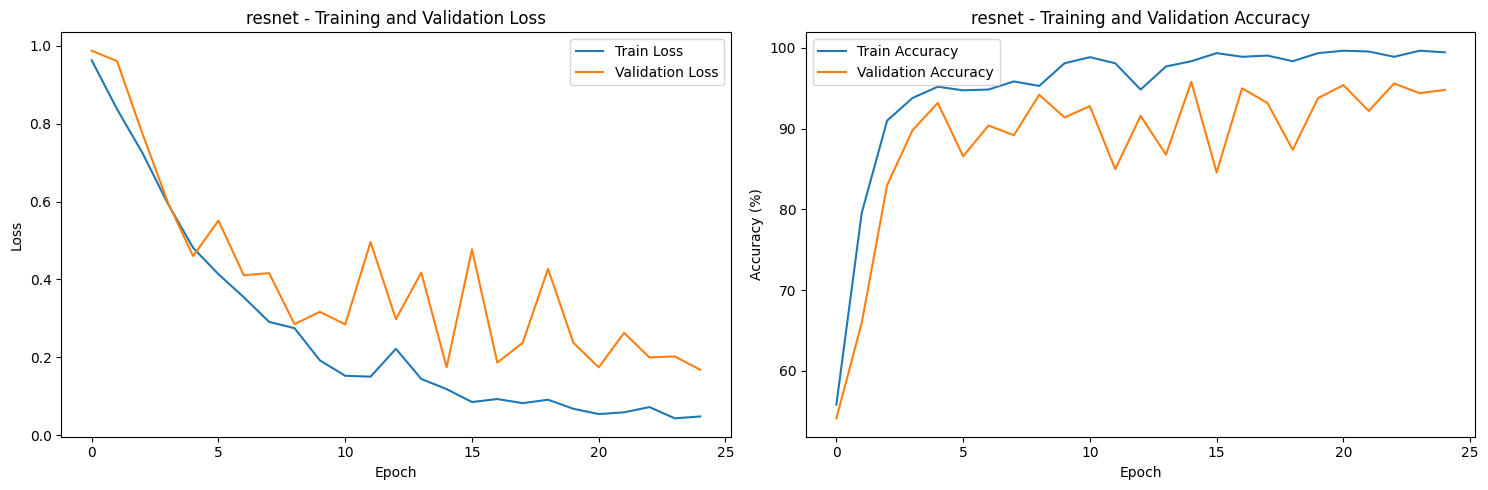

Evaluating resnet hybrid model...

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       165
           1       0.96      0.96      0.96       168
           2       0.97      0.93      0.95       166

    accuracy                           0.95       499
   macro avg       0.95      0.95      0.95       499
weighted avg       0.95      0.95      0.95       499



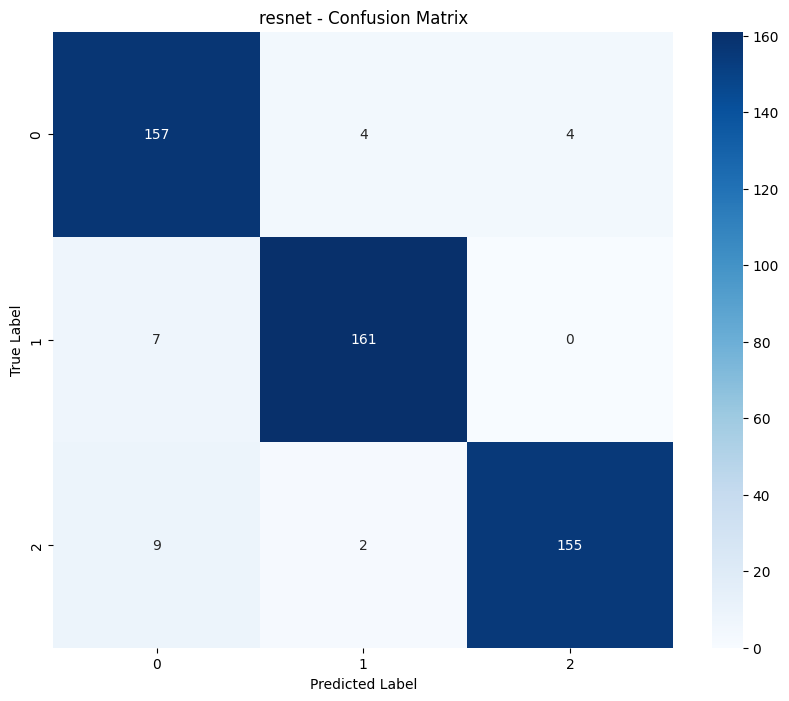

Model saved to /content/drive/MyDrive/BTP-Brain tumour/hybrid_resnet_model.pth
Successfully completed training and evaluation for resnet

Processing VGG hybrid model
Initializing vgg hybrid model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


Successfully loaded pretrained weights for vgg
Training vgg hybrid model...
Epoch [1/25]
Train Loss: 1.1304, Train Acc: 33.72%
Val Loss: 1.1162, Val Acc: 33.67%
------------------------------------------------------------
Epoch [2/25]
Train Loss: 1.1117, Train Acc: 33.47%
Val Loss: 1.1065, Val Acc: 33.67%
------------------------------------------------------------
Epoch [3/25]
Train Loss: 1.1015, Train Acc: 33.32%
Val Loss: 1.1043, Val Acc: 33.67%
------------------------------------------------------------
Epoch [4/25]
Train Loss: 1.1155, Train Acc: 32.57%
Val Loss: 1.1009, Val Acc: 33.67%
------------------------------------------------------------
Epoch [5/25]
Train Loss: 1.1065, Train Acc: 34.12%
Val Loss: 1.1106, Val Acc: 33.67%
------------------------------------------------------------
Epoch [6/25]
Train Loss: 1.1064, Train Acc: 33.17%
Val Loss: 1.1103, Val Acc: 33.67%
------------------------------------------------------------
Epoch [7/25]
Train Loss: 1.1029, Train Acc: 33.4

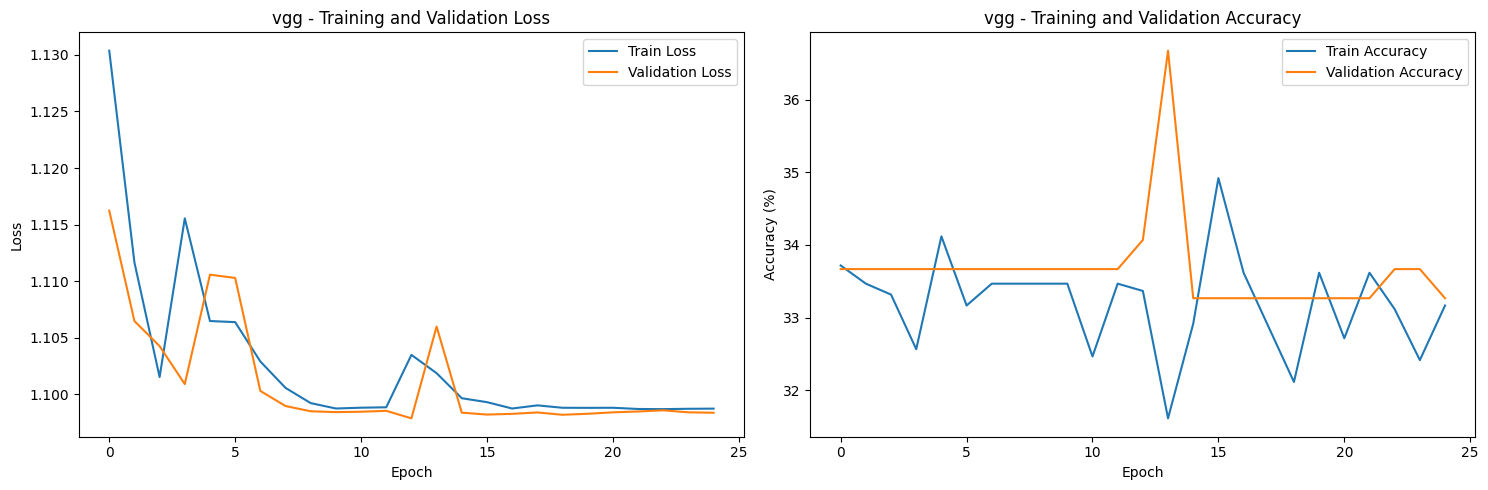

Evaluating vgg hybrid model...

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.00      0.00      0.00       168
           2       0.33      1.00      0.50       166

    accuracy                           0.33       499
   macro avg       0.11      0.33      0.17       499
weighted avg       0.11      0.33      0.17       499



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


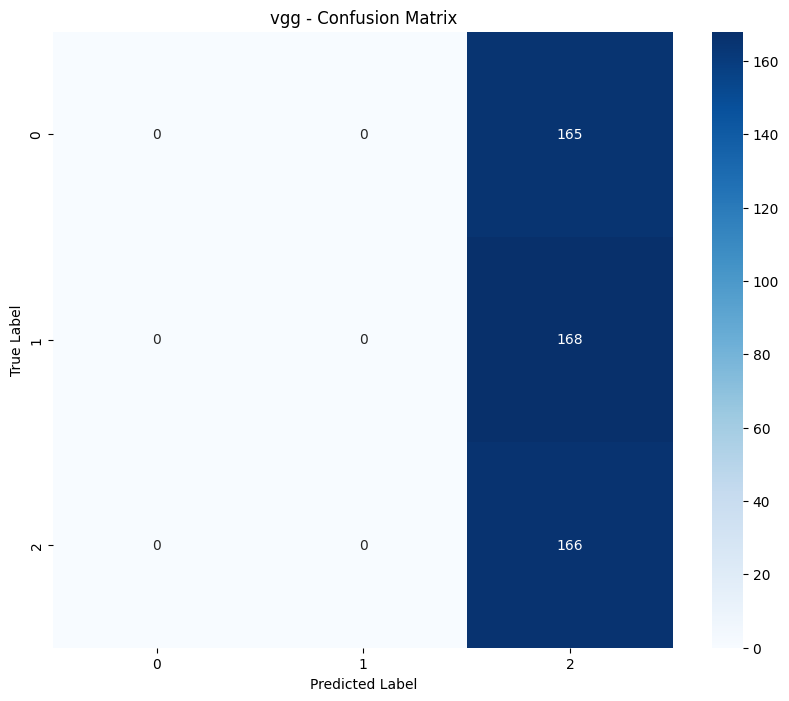

Model saved to /content/drive/MyDrive/BTP-Brain tumour/hybrid_vgg_model.pth
Successfully completed training and evaluation for vgg

Processing MOBILENET hybrid model
Initializing mobilenet hybrid model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.4MB/s]


Successfully loaded pretrained weights for mobilenet
Training mobilenet hybrid model...
Epoch [1/25]
Train Loss: 0.9057, Train Acc: 82.16%
Val Loss: 0.8311, Val Acc: 90.38%
------------------------------------------------------------
Epoch [2/25]
Train Loss: 0.7809, Train Acc: 92.43%
Val Loss: 0.7594, Val Acc: 89.98%
------------------------------------------------------------
Epoch [3/25]
Train Loss: 0.6879, Train Acc: 93.59%
Val Loss: 0.7570, Val Acc: 83.57%
------------------------------------------------------------
Epoch [4/25]
Train Loss: 0.5989, Train Acc: 95.24%
Val Loss: 0.5766, Val Acc: 93.39%
------------------------------------------------------------
Epoch [5/25]
Train Loss: 0.5450, Train Acc: 93.79%
Val Loss: 0.5887, Val Acc: 87.17%
------------------------------------------------------------
Epoch [6/25]
Train Loss: 0.4629, Train Acc: 95.89%
Val Loss: 0.4670, Val Acc: 93.39%
------------------------------------------------------------
Epoch [7/25]
Train Loss: 0.4133, Tra

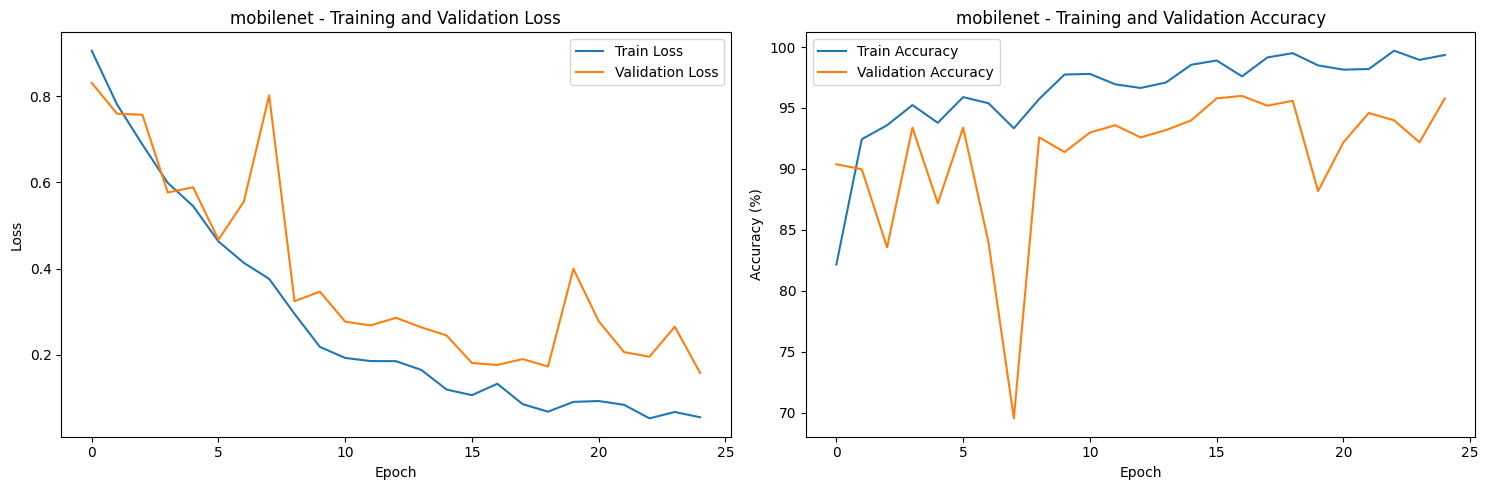

Evaluating mobilenet hybrid model...

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       165
           1       0.96      0.96      0.96       168
           2       0.99      0.95      0.97       166

    accuracy                           0.96       499
   macro avg       0.96      0.96      0.96       499
weighted avg       0.96      0.96      0.96       499



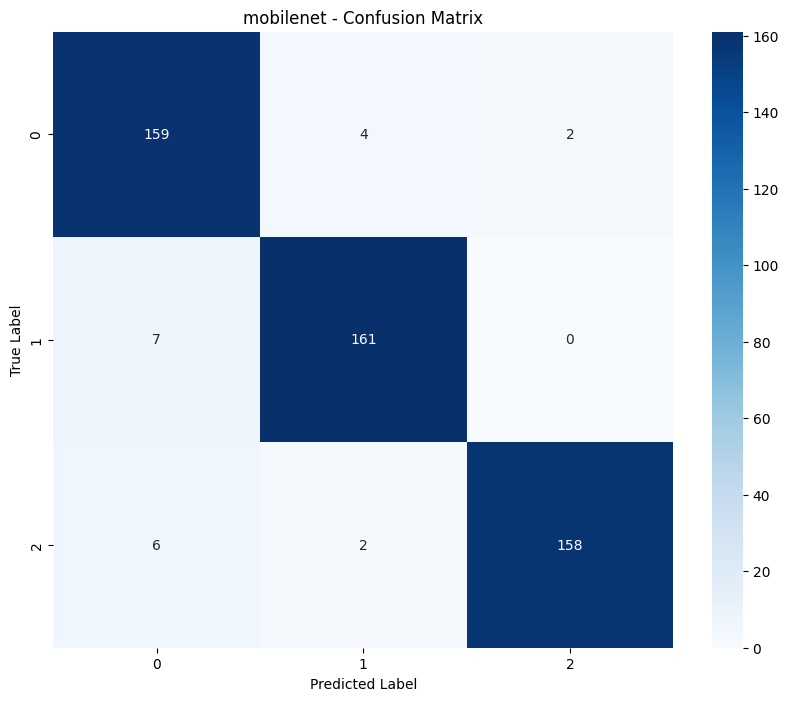

Model saved to /content/drive/MyDrive/BTP-Brain tumour/hybrid_mobilenet_model.pth
Successfully completed training and evaluation for mobilenet

Processing INCEPTION hybrid model
Initializing inception hybrid model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 153MB/s] 


Successfully loaded pretrained weights for inception
Training inception hybrid model...
Epoch [1/25]
Train Loss: 0.8568, Train Acc: 77.45%
Val Loss: 0.8190, Val Acc: 78.76%
------------------------------------------------------------
Epoch [2/25]
Train Loss: 0.6739, Train Acc: 88.28%
Val Loss: 0.7366, Val Acc: 84.17%
------------------------------------------------------------
Epoch [3/25]
Train Loss: 0.5796, Train Acc: 89.93%
Val Loss: 0.5739, Val Acc: 86.77%
------------------------------------------------------------
Epoch [4/25]
Train Loss: 0.4606, Train Acc: 92.84%
Val Loss: 0.5155, Val Acc: 87.37%
------------------------------------------------------------
Epoch [5/25]
Train Loss: 0.4107, Train Acc: 92.08%
Val Loss: 0.5097, Val Acc: 84.57%
------------------------------------------------------------


In [ ]:

def main():
    data_dir = '/content/drive/MyDrive/BTP'

    # Define the paths to the pretrained models
    pretrained_models = {
        'resnet': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/resnet18_model.pth',
        'vgg': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/vgg16_model.pth',
        'mobilenet': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/mobilenet_model.pth',
        'inception': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/inception_model.pth'
    }

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for model_type, pretrained_path in pretrained_models.items():
        print(f"\n{'='*60}")
        print(f"Processing {model_type.upper()} hybrid model")
        print(f"{'='*60}")

        try:
            model, train_acc, val_acc, training_time = train_and_evaluate_model(
                model_type, pretrained_path, data_dir)

            results[model_type] = {
                'train_acc': train_acc,
                'val_acc': val_acc,
                'training_time': training_time
            }

            print(f"Successfully completed training and evaluation for {model_type}")
        except Exception as e:
            print(f"Error with {model_type} model: {str(e)}")

    # Compare model performance
    print("\n\n")
    print("="*80)
    print("MODEL COMPARISON")
    print("="*80)
    print(f"{'Model Type':<15} {'Training Accuracy':<20} {'Validation Accuracy':<20} {'Training Time (s)':<20}")
    print("-"*80)

    for model_type, metrics in results.items():
        print(f"{model_type.capitalize():<15} {metrics['train_acc']:<20.2f} {metrics['val_acc']:<20.2f} {metrics['training_time']:<20.2f}")

    # Find the best model based on validation accuracy
    best_model = max(results.items(), key=lambda x: x[1]['val_acc'])
    print("\nBest performing model:")
    print(f"Model: {best_model[0].capitalize()}")
    print(f"Validation Accuracy: {best_model[1]['val_acc']:.2f}%")
    print(f"Training Time: {best_model[1]['training_time']:.2f} seconds")

# Execute the main function
if __name__ == "__main__":
    main()


Processing INCEPTION hybrid model
Initializing inception hybrid model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 122MB/s] 


Successfully loaded pretrained weights for inception
Training inception hybrid model...
Epoch [1/25]
Train Loss: 0.9600, Train Acc: 61.43%
Val Loss: 0.9311, Val Acc: 60.92%
------------------------------------------------------------
Epoch [2/25]
Train Loss: 0.8657, Train Acc: 63.14%
Val Loss: 0.8139, Val Acc: 64.73%
------------------------------------------------------------
Epoch [3/25]
Train Loss: 0.7887, Train Acc: 72.10%
Val Loss: 0.7510, Val Acc: 80.56%
------------------------------------------------------------
Epoch [4/25]
Train Loss: 0.7274, Train Acc: 87.11%
Val Loss: 0.7562, Val Acc: 81.36%
------------------------------------------------------------
Epoch [5/25]
Train Loss: 0.6694, Train Acc: 88.62%
Val Loss: 0.6932, Val Acc: 80.16%
------------------------------------------------------------
Epoch [6/25]
Train Loss: 0.5956, Train Acc: 91.49%
Val Loss: 0.7203, Val Acc: 81.16%
------------------------------------------------------------
Epoch [7/25]
Train Loss: 0.5525, Tra

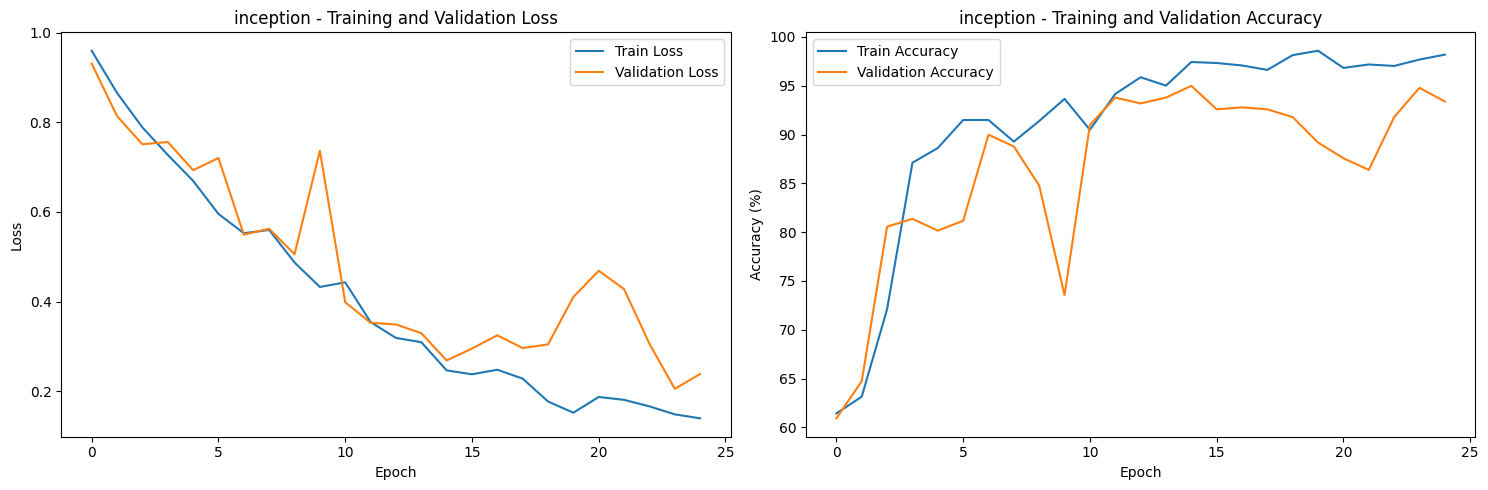

Evaluating inception hybrid model...

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       165
           1       0.99      0.90      0.94       168
           2       0.92      0.99      0.96       166

    accuracy                           0.93       499
   macro avg       0.94      0.93      0.93       499
weighted avg       0.94      0.93      0.93       499



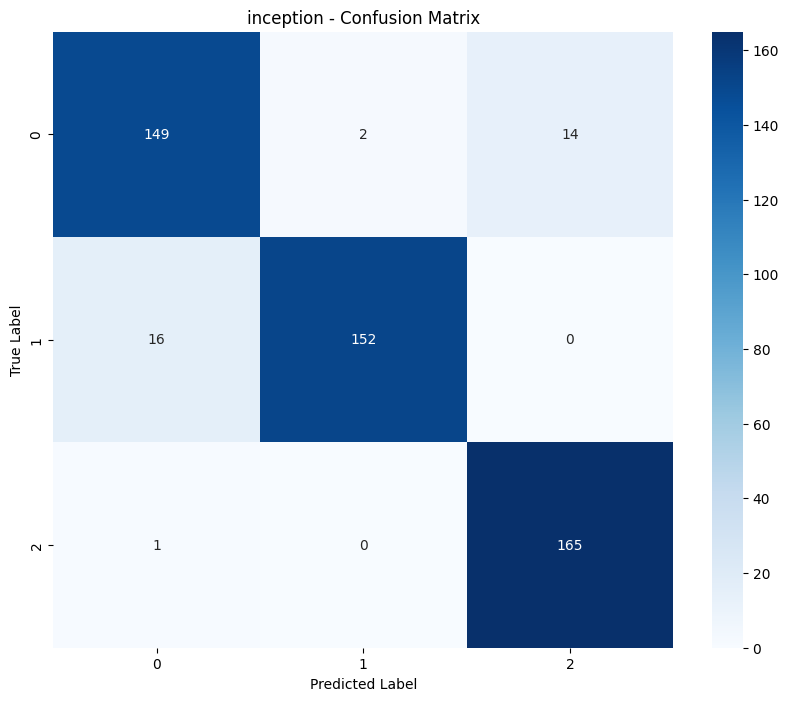

Model saved to /content/drive/MyDrive/BTP/hybrid_inception_model.pth
Successfully completed training and evaluation for inception



MODEL COMPARISON
Model Type      Training Accuracy    Validation Accuracy  Training Time (s)   
--------------------------------------------------------------------------------
Inception       98.19                93.39                3350.57             

Best performing model:
Model: Inception
Validation Accuracy: 93.39%
Training Time: 3350.57 seconds


In [ ]:

def main():
    data_dir = '/content/drive/MyDrive/BTP'

    # Define the paths to the pretrained models

        # 'resnet': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/resnet18_model.pth',
        # 'vgg': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/vgg16_model.pth',
        # 'mobilenet': '/content/drive/MyDrive/BTP-Brain tumour/saved_models/mobilenet_model.pth',
    pretrained_models = {
        'inception': '/content/drive/MyDrive/BTP/inception_model.pth'
    }

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for model_type, pretrained_path in pretrained_models.items():
        print(f"\n{'='*60}")
        print(f"Processing {model_type.upper()} hybrid model")
        print(f"{'='*60}")

        try:
            model, train_acc, val_acc, training_time = train_and_evaluate_model(
                model_type, pretrained_path, data_dir)

            results[model_type] = {
                'train_acc': train_acc,
                'val_acc': val_acc,
                'training_time': training_time
            }

            print(f"Successfully completed training and evaluation for {model_type}")
        except Exception as e:
            print(f"Error with {model_type} model: {str(e)}")

    # Compare model performance
    print("\n\n")
    print("="*80)
    print("MODEL COMPARISON")
    print("="*80)
    print(f"{'Model Type':<15} {'Training Accuracy':<20} {'Validation Accuracy':<20} {'Training Time (s)':<20}")
    print("-"*80)

    for model_type, metrics in results.items():
        print(f"{model_type.capitalize():<15} {metrics['train_acc']:<20.2f} {metrics['val_acc']:<20.2f} {metrics['training_time']:<20.2f}")

    # Find the best model based on validation accuracy
    best_model = max(results.items(), key=lambda x: x[1]['val_acc'])
    print("\nBest performing model:")
    print(f"Model: {best_model[0].capitalize()}")
    print(f"Validation Accuracy: {best_model[1]['val_acc']:.2f}%")
    print(f"Training Time: {best_model[1]['training_time']:.2f} seconds")

# Execute the main function
if __name__ == "__main__":
    main()

In [ ]:
!pip install streamlit

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

class ModelInferenceApp:
    def __init__(self, models, class_names, device):
        """
        Initialize the inference application

        Args:
            models (dict): Dictionary of trained models {model_name: model}
            class_names (list): List of class names
            device (torch.device): Computational device
        """
        self.models = models
        self.class_names = class_names
        self.device = device

        # Preprocessing transforms
        self.transforms = {
            'resnet': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            'vgg': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            'mobilenet': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            'inception': transforms.Compose([
                transforms.Resize((299, 299)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        }

    def preprocess_image(self, image, model_type):
        """
        Preprocess image for a specific model

        Args:
            image (PIL.Image): Input image
            model_type (str): Type of model (resnet, vgg, etc.)

        Returns:
            torch.Tensor: Preprocessed image tensor
        """
        transform = self.transforms[model_type]
        return transform(image).unsqueeze(0).to(self.device)

    def predict(self, image):
        """
        Get predictions from all models

        Args:
            image (PIL.Image): Input image

        Returns:
            dict: Predictions from each model
        """
        predictions = {}

        for model_name, model in self.models.items():
            # Determine model-specific preprocessing
            if 'inception' in model_name.lower():
                preprocessed_image = self.preprocess_image(image, 'inception')
            else:
                preprocessed_image = self.preprocess_image(image, 'resnet')

            # Set model to evaluation mode
            model.eval()

            # Inference
            with torch.no_grad():
                outputs = model(preprocessed_image)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)

                # Get top 3 predictions
                top_probs, top_indices = torch.topk(probabilities, 3)

                # Convert to numpy for easier processing
                top_probs = top_probs.cpu().numpy()[0]
                top_indices = top_indices.cpu().numpy()[0]

                # Prepare prediction details
                model_predictions = []
                for prob, idx in zip(top_probs, top_indices):
                    model_predictions.append({
                        'class': self.class_names[idx],
                        'probability': float(prob)
                    })

                predictions[model_name] = model_predictions

        return predictions

    def visualize_predictions(self, image, predictions):
        """
        Create a visualization of model predictions

        Args:
            image (PIL.Image): Original input image
            predictions (dict): Predictions from all models

        Returns:
            matplotlib figure
        """
        # Create figure with subplots
        fig, axs = plt.subplots(len(predictions)+1, 1, figsize=(10, 4*len(predictions)+4))

        # Display original image
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        # Display predictions for each model
        for i, (model_name, preds) in enumerate(predictions.items(), 1):
            # Create prediction text
            pred_text = f"{model_name} Predictions:\n"
            for pred in preds:
                pred_text += f"{pred['class']}: {pred['probability']:.2%}\n"

            axs[i].text(0.5, 0.5, pred_text,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=10)
            axs[i].set_title(f'{model_name} Predictions')
            axs[i].axis('off')

        plt.tight_layout()
        return fig

def create_streamlit_app(models, class_names, device):
    """
    Create a Streamlit application for model inference

    Args:
        models (dict): Dictionary of trained models
        class_names (list): List of class names
        device (torch.device): Computational device
    """
    # Initialize the inference app
    inference_app = ModelInferenceApp(models, class_names, device)

    # Streamlit app
    st.title('Multi-Model Brain Tumor Classification')

    # File uploader
    uploaded_file = st.file_uploader(
        "Choose a brain MRI image...",
        type=['jpg', 'jpeg', 'png', 'dcm', 'tiff']
    )

    if uploaded_file is not None:
        # Read the image
        image = Image.open(uploaded_file)

        # Display uploaded image
        st.image(image, caption='Uploaded Image', use_column_width=True)

        # Predict
        st.write('Running inference...')
        predictions = inference_app.predict(image)

        # Create and display prediction visualization
        fig = inference_app.visualize_predictions(image, predictions)
        st.pyplot(fig)

        # Detailed predictions
        st.subheader('Detailed Predictions')
        for model_name, preds in predictions.items():
            st.write(f"**{model_name} Predictions:**")
            pred_df = pd.DataFrame(preds)
            st.dataframe(pred_df)

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Class names (adjust based on your dataset)
    class_names = ['Normal', 'Benign', 'Malignant']

    # Load trained models (adjust paths and model classes as needed)
    models = {
        'ResNet18': ResNet18Hybrid(num_classes=3).to(device),
        'VGG16': VGG16Hybrid(num_classes=3).to(device),
        'MobileNetV2': MobileNetV2Hybrid(num_classes=3).to(device),
        'InceptionV3': InceptionV3Hybrid(num_classes=3).to(device)
    }

    # Load model weights (adjust paths as needed)
    model_paths = {
        'ResNet18': 'resnet18_hybrid_model.pth',
        'VGG16': 'vgg16_hybrid_model.pth',
        'MobileNetV2': 'mobilenet_hybrid_model.pth',
        'InceptionV3': 'inception_hybrid_model.pth'
    }

    # Load weights for each model
    for model_name, model in models.items():
        model.load_state_dict(torch.load(model_paths[model_name], map_location=device))
        model.eval()

    # Run Streamlit app
    create_streamlit_app(models, class_names, device)

if __name__ == "__main__":
    main()